In [1]:
%cd -q ..

In [2]:
from IPython.core.magic import register_cell_magic
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3

from src.utils import create_views

In [3]:
sns.set_style("darkgrid")
plt.rcParams.update({
    "figure.dpi": 150,
})

In [4]:
conn = sqlite3.connect("data/posts.sqlite")
create_views(conn.cursor())

@register_cell_magic
def sql(line, cell):
    name, *params = line.split()
    params = params or None
    g = globals()
    
    try:
        df = pd.read_sql_query(cell, con=conn, params=params)
    except Exception as e:
        print(e)
        return

    if name != "display":
        g.update({name: df})
        return
    return df

## Summarize

In [5]:
%%sql display
-- See what's available.
select
    (select count(*) from submissions) as n_submissions,
    (select count(*) from albums) as n_albums,
    (select count(*) from images) as n_images,
    (select count(img) from images) as n_images_with_image

,n_submissions,n_albums,n_images,n_images_with_image
0,428,460,5116,5113


In [6]:
%%sql display
-- Which search yielded more results?
select
    search_query,
    count(*) as n
from submissions
group by search_query

,search_query,n
0,impression,249
1,review,179


In [7]:
%%sql display
-- How many submissions have attached media?
select
    has_media,
    count(*) as n
from (
    select
        case when
            m.id is null then false
            else true
        end as has_media
    from submissions as s
    left outer join medias as m
    on s.id = m.submission_id
) as t

,has_media,n
0,1,808


In [8]:
%%sql media_frequencies
-- Number of medias attached to each submission.
-- NB: Media is an abstract concept here - may be more concerned
--     with raw image count.
select
    n_medias,
    count(*) as frequency
from (
    select
        count(*) as n_medias
    from medias
    group by submission_id
)
group by n_medias

Text(0, 0.5, 'Frequency')

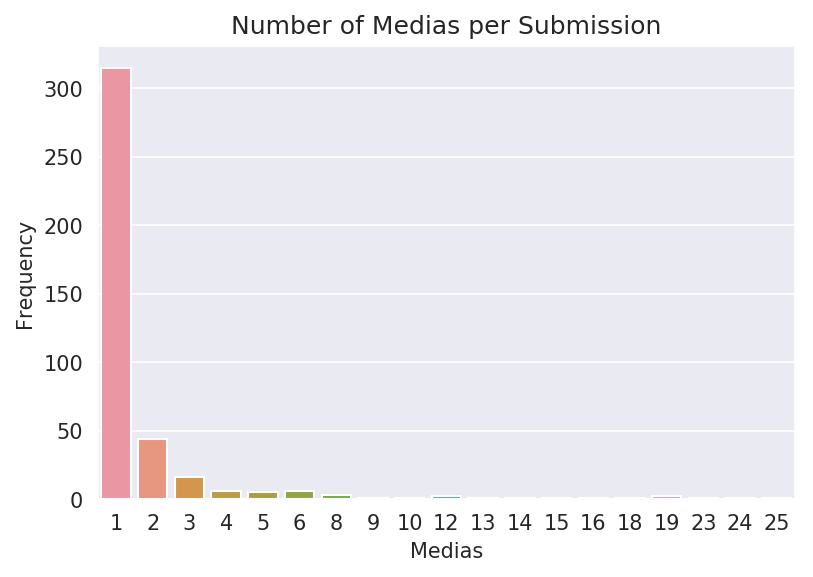

In [9]:
ax = sns.barplot(x="n_medias", y="frequency", data=media_frequencies)
ax.set_title("Number of Medias per Submission")
ax.set_xlabel("Medias")
ax.set_ylabel("Frequency")

In [10]:
%%sql display
-- Direct (part of submission) or not (linked in post).
select
    is_direct,
    count(*) as n
from medias
group by is_direct

,is_direct,n
0,0,696
1,1,93


In [11]:
%%sql media_by_type
-- Number of medias per direct/linked type.
select
    case when
        is_direct then 'Direct'
        else 'Linked'
    end as media_type,
    n_medias,
    count(*) as frequency
from (
    select
        is_direct,
        count(*) as n_medias
    from medias
    group by submission_id, is_direct
)
group by n_medias, media_type

Text(0, 0.5, 'Frequency')

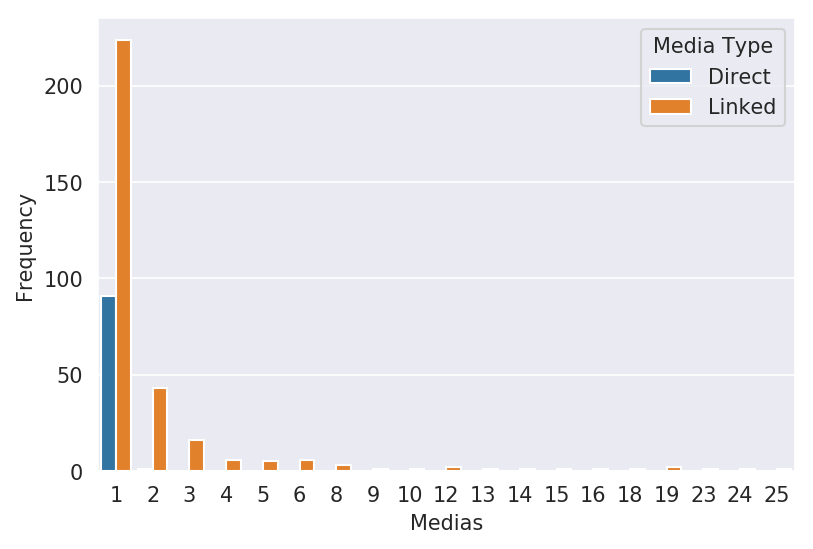

In [12]:
ax = sns.barplot(x="n_medias", y="frequency", hue="media_type", data=media_by_type)
ax.legend_.set_title("Media Type")
ax.set_xlabel("Medias")
ax.set_ylabel("Frequency")

In [13]:
%%sql n_image_frequencies
select
    n_images as images,
    count(*) as frequency
from (
    select
        count(*) as n_images
    from images
    where album_id is not null
    group by album_id
)
group by n_images

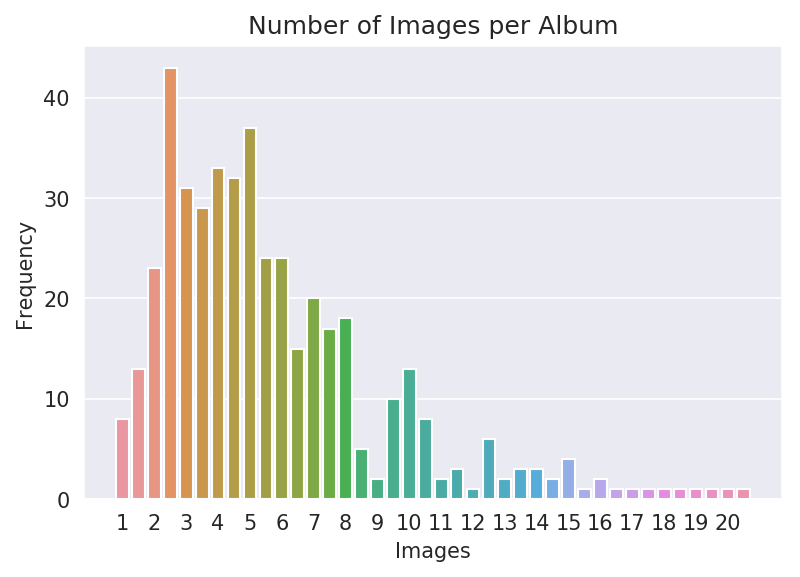

In [14]:
ax = sns.barplot(x="images", y="frequency", data=n_image_frequencies)
ax.set_title("Number of Images per Album")
ax.set_xlabel("Images")
ax.set_ylabel("Frequency")
ax.locator_params(axis="x", nbins=20)

In [15]:
%%sql display
-- Number of "orphan" images.
select
    count(*) as n_images_wo_album
from images
where album_id is null

,n_images_wo_album
0,195


In [16]:
%%sql display
-- Reddit's measures of popularity, as it were.
select
    min(comments) as min_comments,
    max(comments) as max_comments,
    min(downs) as min_downvotes,
    max(downs) as max_downvotes,
    min(ups) as min_upvotes,
    max(ups) as max_upvotes,
    min(gilded) as min_gilds,
    max(gilded) as max_gilds
from submissions

,min_comments,max_comments,min_downvotes,max_downvotes,min_upvotes,max_upvotes,min_gilds,max_gilds
0,0,132,0,0,0,347,0,1


In [17]:
%%sql comment_frequencies
-- Distribution of comments.
select
    comments,
    count(*) as frequency
from submissions
group by comments

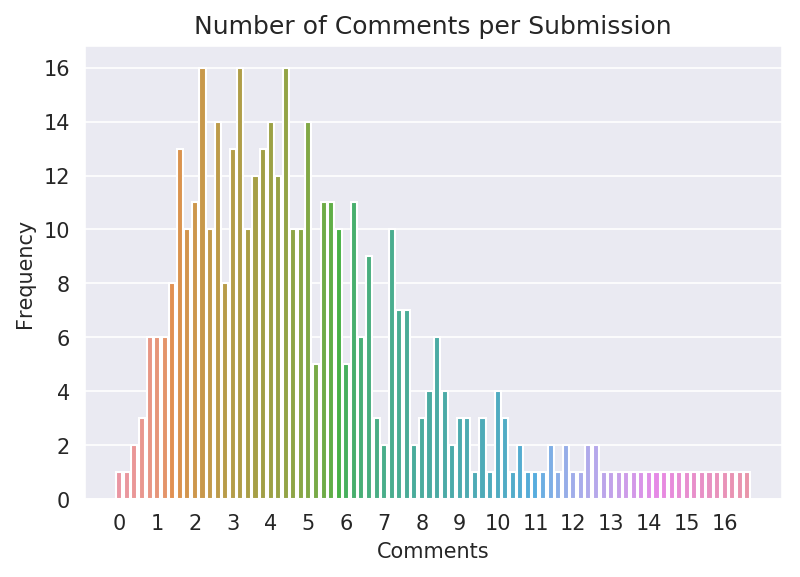

In [18]:
ax = sns.barplot(x="comments", y="frequency", data=comment_frequencies)
ax.set_title("Number of Comments per Submission")
ax.set_xlabel("Comments")
ax.set_ylabel("Frequency")
ax.locator_params(axis="x", nbins=20)

In [19]:
%%sql display
-- How many submissions have a textual body (i.e. post)?
select
    has_post,
    count(*) as n_submissions
from (
    select
        case
            when selftext_html is null then false
            when selftext_html = '' then false
            else true
        end as has_post
    from submissions
)
group by has_post

,has_post,n_submissions
0,0,96
1,1,332


In [20]:
%%sql display
-- How many images have descriptions?
-- Image descriptions in an album are sometimes used in lieue of a post.
select
    has_description,
    count(*) as n_images
from (
    select
        case
            when description is null then false
            when description = '' then false
            else true
        end as has_description
    from images
)
group by has_description

,has_description,n_images
0,0,3561
1,1,1555


In [21]:
%%sql display
-- How many _submissions_ have images with descriptions within an album?
select
    sum(has_description) as n_submissions_with_album_and_with_image_descriptions,
    (select count(id) from submissions) as n_submissions
from medias
inner join (
    select
        media_id,
        sum(
            case
                when description is null then 0
                when description = '' then 0
                else 1
            end
        ) > 0 as has_description
    from images
    where album_id is not null
    group by media_id
) as t
on medias.id = t.media_id
inner join submissions
on medias.submission_id = submissions.id

,n_submissions_with_album_and_with_image_descriptions,n_submissions
0,183,428


In [22]:
%%sql display
-- Album descriptions?
select
    has_description,
    count(*) as n_albums
from (
    select
        case
            when description is null then false
            when description = '' then false
            else true
        end as has_description
    from albums
)
group by has_description

,has_description,n_albums
0,0,449
1,1,11


In [23]:
%%sql display
select distinct description from albums

,description
0,None
1,Size 9.5 Java Waxed Flesh Boots
2,null
3,Natural Waxed Flesh - Mini Ripple Sole
4,Picturs of my Giau biots from Zeb Shoes
5,White’s MP Service Boots in Cinnamon Waxed Flesh
6,shared version
7,Taft Dragon Boot


Very few albums have descriptions, and those that do have ones that most likely
do not add information beyond what is available in the submission.

In [24]:
%%sql display 20
-- Frequent authors?
select
    author,
    count(*) as n_submissions
from submissions
group by author
order by count(*) desc
limit ?

,author,n_submissions
0,fasthall,6
1,lostrock,6
2,methanol88,5
3,AwesomeAndy,4
4,Floopsysanders,4
5,JupiterIsBeautiful,4
6,RightLow,4
7,iamntbatman,4
8,sleepauger,4
9,Bouzal,3


## Characteristics of Top Submissions

In [25]:
%%sql display 20
-- By upvotes.
select
    submission_title,
    author,
    comments,
    downs,
    ups,
    gilded,
    length(coalesce(selftext_html, '')) as post_length,
    n_albums,
    total_album_views,
    total_images,
    length(coalesce(posts, '')) as album_text_length
from rollups
order by ups desc
limit ?

,submission_title,author,comments,downs,ups,gilded,post_length,n_albums,total_album_views,total_images,album_text_length
0,"[Initial Impressions] Booty, Bane of Foot and ...",Suissi,44,0,347,1,3746,1.0,658.0,6.0,643
1,[Initial Impressions] Viberg Crust Horsehide,Rymanocerous,54,0,314,0,0,0.0,NaN,1.0,0
2,[Initial Impressions] Crockett &amp; Jones Tea...,Milkable,42,0,285,0,0,0.0,NaN,1.0,0
3,My Ugly Homemade Boots Made Me Appreciate The ...,Suissi,53,0,255,0,2269,1.0,882.0,13.0,1387
4,[ 3 month review] Thorogood Dodgeville boots (...,BiomedDood,58,0,245,0,0,0.0,NaN,1.0,0
5,[Initial Impressions] Viberg Tobacco Chromepak...,MrHuckleberryFinn,103,0,238,0,0,1.0,1072.0,33.0,2530
6,Initial impressions Chippewa 4353TAN Service b...,PirkDiggler,63,0,216,0,0,0.0,NaN,1.0,0
7,[Initial Impressions] Allen Edmonds Shell Cord...,CommisarKek,53,0,211,0,0,0.0,NaN,1.0,0
8,[Initial Impressions] Alden Color 8 PCT's from...,Milkable,47,0,193,0,0,0.0,NaN,1.0,0
9,Go-to Brands for Dress Boots - Budget options ...,guisess93,114,0,190,0,13880,NaN,NaN,NaN,0


Something of a mixed bag. These all seem to have a relatively high number of
comments, though. A lot don't have text, although users put the writeup as a
comment to their own thread relatively frequently.

In [26]:
%%sql display 20
-- By comments.
select
    submission_title,
    author,
    comments,
    downs,
    ups,
    gilded,
    length(coalesce(selftext_html, '')) as post_length,
    n_albums,
    total_album_views,
    total_images,
    length(coalesce(posts, '')) as album_text_length
from rollups
order by comments desc
limit ?

,submission_title,author,comments,downs,ups,gilded,post_length,n_albums,total_album_views,total_images,album_text_length
0,"OK - who's a Brannock 12D, likes boots and wan...",M635_Guy,132,0,175,0,0,0.0,NaN,1.0,0
1,Layer-0 Double feature 6-hole boots,sinnedk1,117,0,64,0,4034,1.0,1181.0,9.0,0
2,Go-to Brands for Dress Boots - Budget options ...,guisess93,114,0,190,0,13880,NaN,NaN,NaN,0
3,For Those Asking For A Worn-In Thursday Boots ...,tinman915,109,0,76,0,2590,1.0,677.0,6.0,0
4,Goodyearwelt Inspo Album- Collection of photos...,Rioc45,108,0,130,0,0,1.0,1684.0,111.0,0
5,[Initial Impressions] Viberg Tobacco Chromepak...,MrHuckleberryFinn,103,0,238,0,0,1.0,1072.0,33.0,2530
6,Original 1000 mile boots - A beginner's boot? ...,jkanphoto,99,0,169,1,13260,1.0,466.0,20.0,2280
7,"My First GYW Boots: Thursday's Vanguard, Limit...",briant1234,95,0,90,0,0,1.0,704.0,9.0,0
8,Another Thursday Review,Jaydubery,91,0,12,0,2385,1.0,616.0,6.0,0
9,Thursday Boot Co.'s Presidents in Natural CXL,NickTDesigns,90,0,65,0,4748,1.0,801.0,8.0,0


Oops. More than a few of these aren't reviews! These mostly seem to have
non-empty posts, though.

# Sanity Checks

In [27]:
%%sql display
-- Double check returned image data.
-- Note that `mimetype` is from the response headers, not metadata.
select
    case when
        mimetype is null then 'Missing'
        else mimetype
    end as mimetype,
    count(*) as n
from images
group by mimetype

,mimetype,n
0,Missing,3
1,image/gif,1
2,image/jpeg,4984
3,image/png,89
4,text/html;charset=UTF-8,37
5,video/mp4,2


In [28]:
%%sql display
-- Look at the links which have unexpected mimetypes.
select
    mimetype,
    url
from images
where
    mimetype is null
    or mimetype like 'text/html%'
order by mimetype, url

,mimetype,url
0,None,https://redd.it/7rw5ub
1,None,https://redd.it/8zn2od
2,None,https://redd.it/9dv74s
3,text/html;charset=UTF-8,http://imgur.com/vhga2No
4,text/html;charset=UTF-8,https://imgur.com/8PJyOeI
5,text/html;charset=UTF-8,https://imgur.com/9jiqiQA
6,text/html;charset=UTF-8,https://imgur.com/Aj3BkzF
7,text/html;charset=UTF-8,https://imgur.com/CQUzXLj
8,text/html;charset=UTF-8,https://imgur.com/GZqErhc
9,text/html;charset=UTF-8,https://imgur.com/IJSz2ze


In [29]:
%%sql display
-- Investigate some irregularities that show in the logs.
select
    url
from medias
where
    url like '%comment%'
    or url like '%/r/%'
    or url like '%http%://redd.it%'
    or url like '%reddit.com%'

,url
0,https://imgur.com/r/goodyearwelt/Zs4TI
1,https://redd.it/8zn2od
2,https://redd.it/9dv74s
3,https://redd.it/7rw5ub


In [30]:
%%sql display
-- Data domain constraints on `submissions` that aren't in the schema.
select
    sum(case when created_utc < 0 then true else false end) as n_timestamps_negative,
    sum(case when gilded < 0 then true else false end) as n_gilded_negative,
    sum(case when comments < 0 then true else false end) as n_comments_negative,
    sum(case when downs < 0 then true else false end) as n_downs_negative,
    sum(case when ups < 0 then true else false end) as n_ups_negative
from submissions

,n_timestamps_negative,n_gilded_negative,n_comments_negative,n_downs_negative,n_ups_negative
0,0,0,0,0,0


In [31]:
%%sql display
-- Data domain constraints on `albums` that aren't in the schema.
select
    sum(case when uploaded_utc < 0 then true else false end) as n_timestamps_negative,
    sum(case when views < 0 then true else false end) as n_views_negative,
    sum(case when length(url) = 0 then true else false end) as n_urls_empty
from albums

,n_timestamps_negative,n_views_negative,n_urls_empty
0,0,0,0


In [32]:
conn.close()